In [1]:
setwd('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/Experiments/1. Compartment Analysis/1.4. Clustering Analyses/1.4.1. Kmeans Clustering/1.4.1.3. Validation Baseline Clusters/Input')
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/Experiments/1. Compartment Analysis/1.4. Clustering Analyses/1.4.1. Kmeans Clustering/1.4.1.3. Validation Baseline Clusters/Output')
cur_date = "052221"

library(readxl)
library(data.table)
library(factoextra)
library(dplyr)
library(tidyverse)
library(gridExtra)
library(cluster)
library(vegan)
library(fpc)
library(ggpubr)
library(ggdendro)
library(NbClust)
library(ggrepel)


#reading in files
cytokines <- data.frame(read_excel("CytokineData_032521.xlsx", sheet = 2))

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.6     ✔ purrr   0.3.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


Attaching package: ‘gridExtra’


The f

This is an analysis to determine how baseline cytokines cluster (using k means) and to get their corresponding eigencytokines by compartment. Want to get clusters that are similar to those in previous dataset. 

In [2]:
#either pivot wider or dcast works
#cytokines %>%
    #filter(Group == 'NS') %>%
    #select(-Compartment, -SubjectNo, -Conc_pslog2, -Group) %>%
    #pivot_wider(names_from = Protein, values_from = Conc_pslog2)

new_dataset_only_cytokines = c("GMCSF", "IL12p40", "IL15", "IL16", "IL17","IL1a", "IL2", "IL5", "IL7", "MCP4", "MDC","TNFb", "VEGF")
`%notin%` <- Negate(`%in%`)
#changing format of df
cytokines = cytokines %>% 
    #only want non-smokers for baseline analysis & cytokines that were in the previous dataset
    filter(Group == 'NS', Protein %notin% new_dataset_only_cytokines) 

cytokines = reshape2::dcast(cytokines, SubjectID ~ Protein, value.var = "Conc_pslog2") %>% 
    column_to_rownames("SubjectID")
head(cytokines)

,Eotaxin,Eotaxin3,IFNg,IL10,IL12p70,IL13,IL1b,IL4,IL6,IL8,IP10,MCP1,MIP1a,MIP1b,TARC,TNFa
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NS_1,6.774771,7.335998,2.704812,0.8786819,0.000000,4.785805,3.262154,0.0498162,2.492767,12.14873,12.63683,9.060861,4.691125,6.580974,4.697691,1.334133
NS_10,7.961318,3.561784,1.501174,2.5216022,1.432708,5.829412,4.764787,0.6891918,3.223890,13.22637,11.95278,8.500505,5.566914,6.477874,5.246138,1.824765
NS_11,5.798693,4.237103,4.414765,3.8879369,4.383899,7.105202,6.938635,2.0105616,5.776803,15.86950,12.13311,8.189456,8.093461,9.867748,4.656334,2.910183
NS_12,5.606658,3.133612,2.708182,3.1291210,2.299339,6.466481,7.488170,1.8008996,5.191662,14.80805,10.22781,8.620419,5.747543,6.722344,4.390556,2.917108
NS_13,6.852042,5.164080,3.038039,3.5726212,1.830181,6.184908,5.121462,1.5217692,4.038158,14.95516,10.30369,8.701979,5.674439,6.255670,5.056091,2.300050
NS_14,9.230327,7.794502,3.233542,3.8174349,2.661157,6.419010,5.197585,1.8875928,3.796112,15.43080,13.31953,9.179177,6.201197,7.425878,6.318897,2.961765


# Baseline Clusters

First, we can estimate the optimal number of clusters, as described in:
- https://afit-r.github.io/kmeans_clustering
- https://www.datanovia.com/en/lessons/k-means-clustering-in-r-algorith-and-practical-examples/
- https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/

> - Compute k-means clustering using different values of clusters k
> - Next, the wss (within sum of square) is drawn according to the number of clusters
> - The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters.
> - The R function fviz_nbclust() [in factoextra package] provides a convenient solution to estimate the optimal number of clusters.

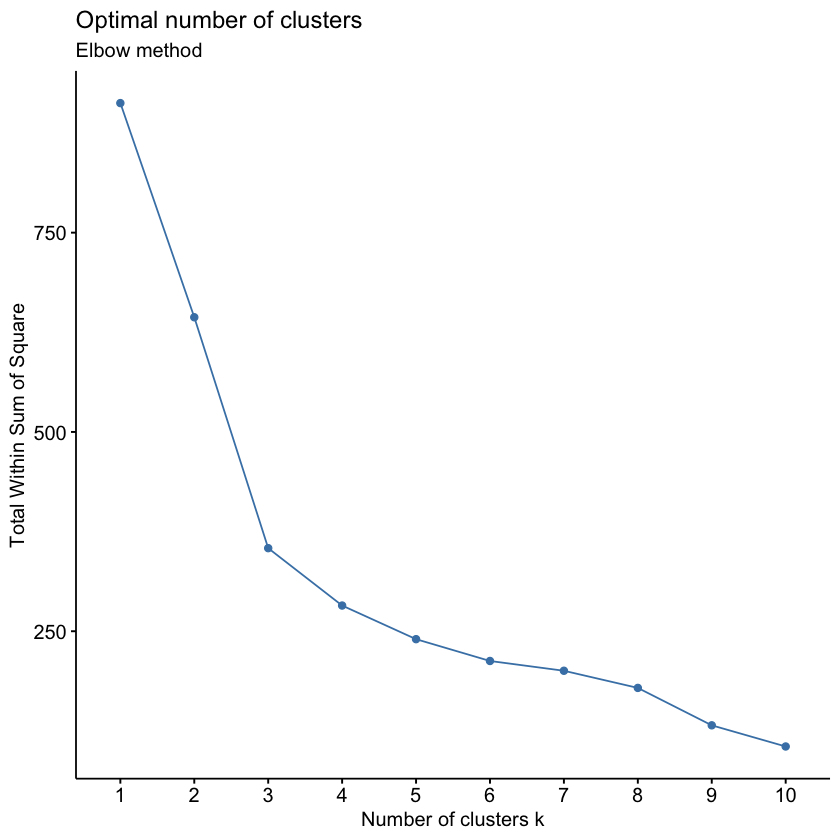

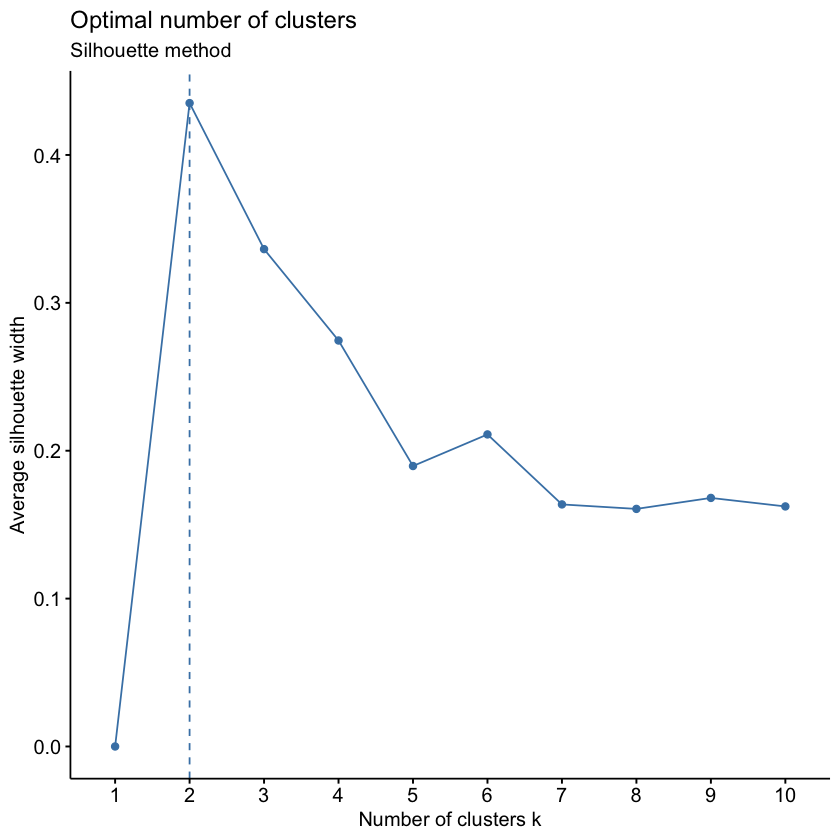

In [3]:
fviz_nbclust(cytokines, kmeans, method = "wss") +
  # The generated plot represents the variance within the clusters. It decreases as k increases, but it can be seen a bend (or “elbow”) at k = 4
  labs(subtitle = "Elbow method") # suggests 3
fviz_nbclust(cytokines, kmeans, method = "silhouette") + 
  labs(subtitle="Silhouette method") # suggests 2 

Run the cluster code using the identified number of clusters for subjects first.

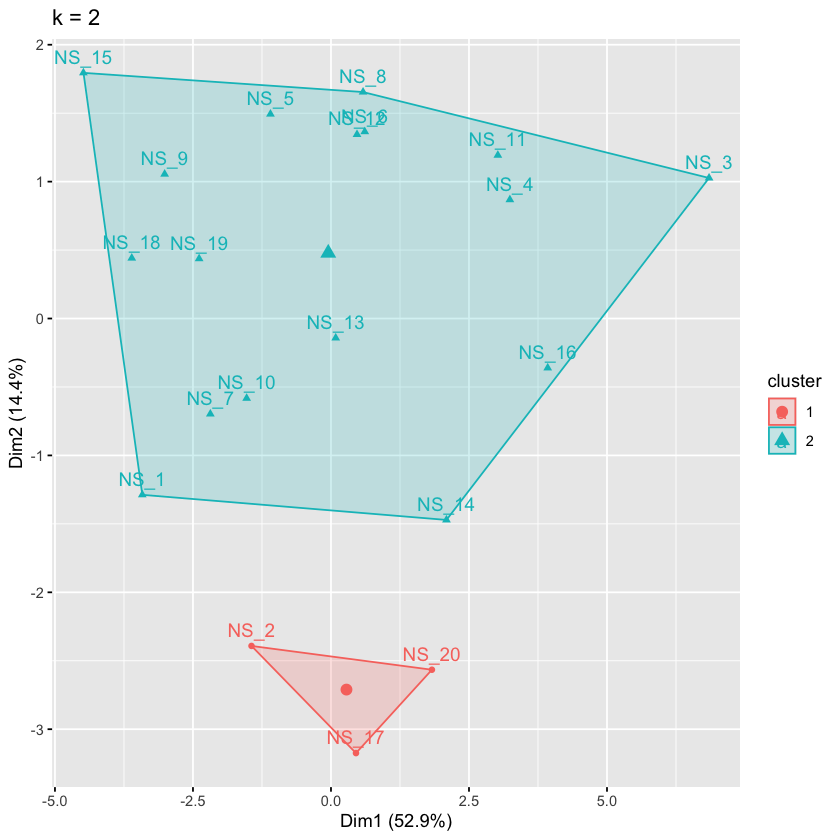

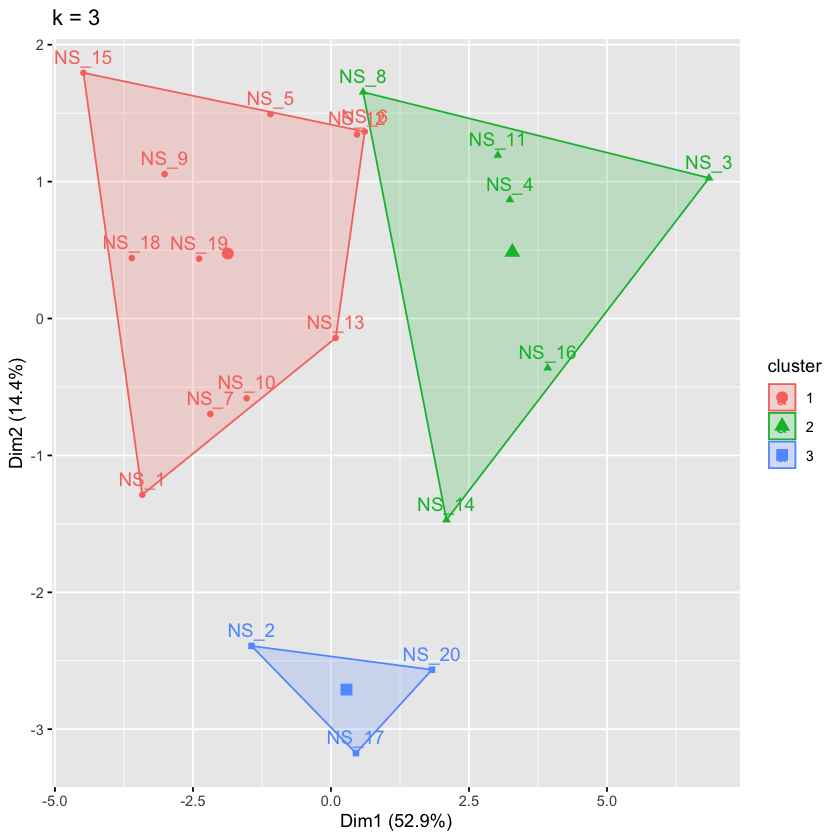

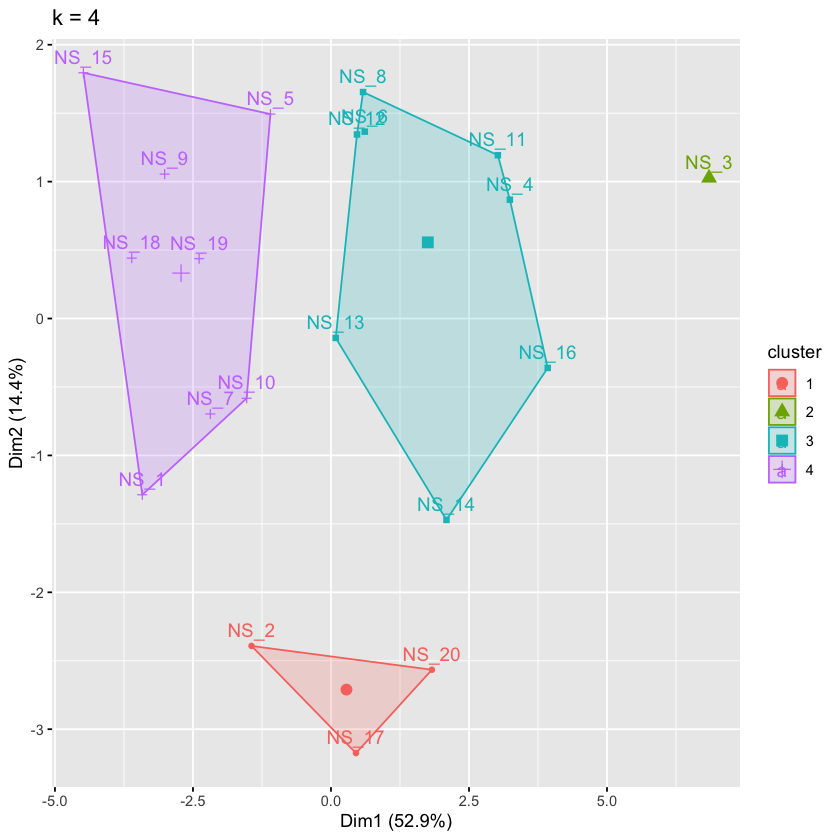

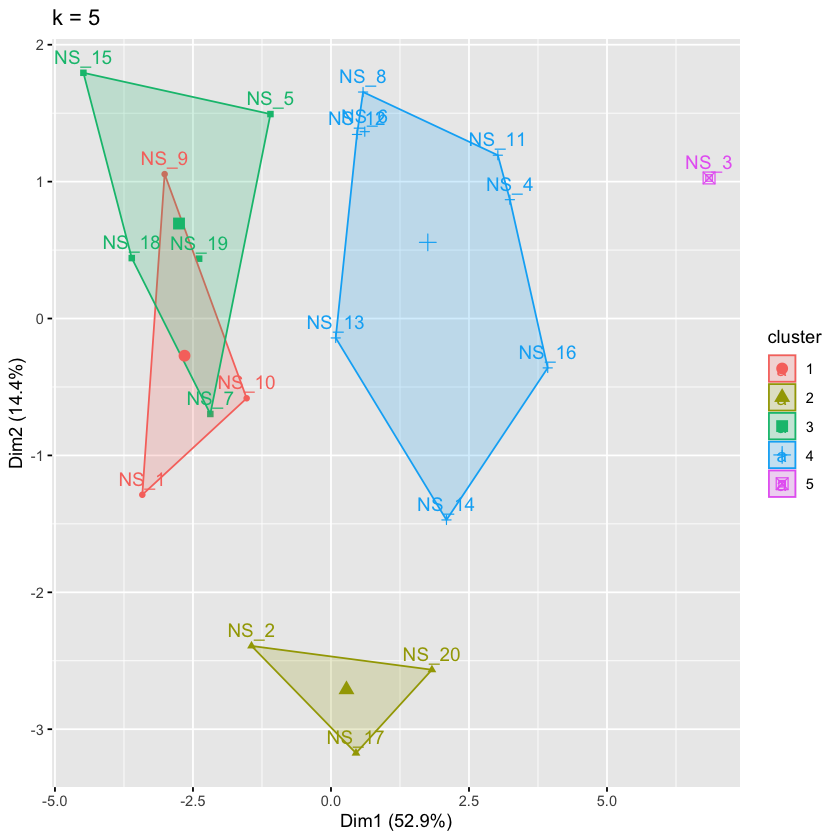

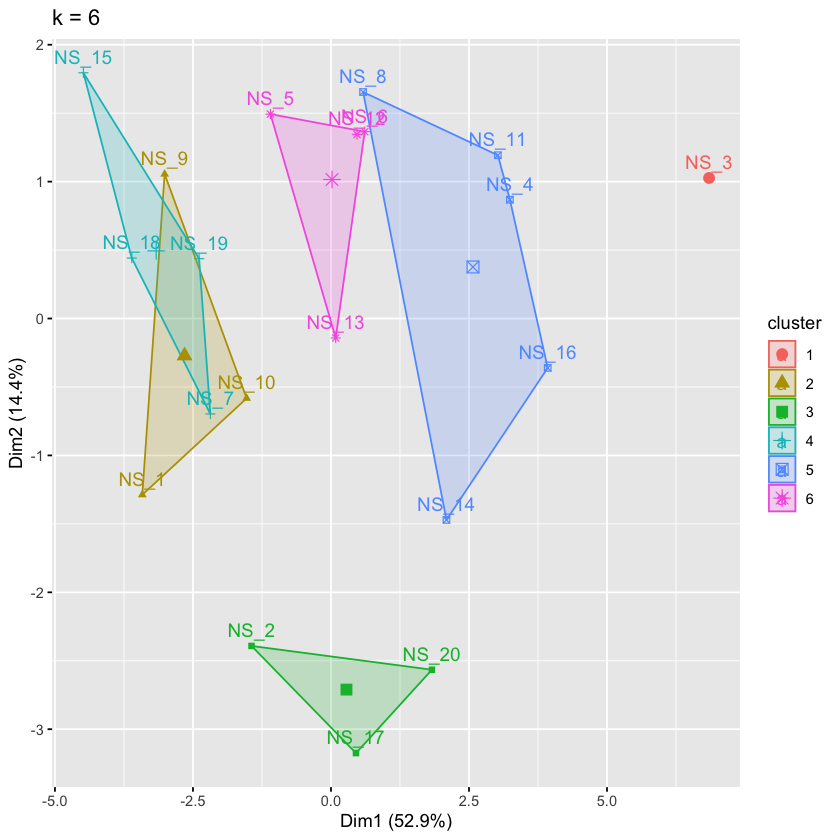

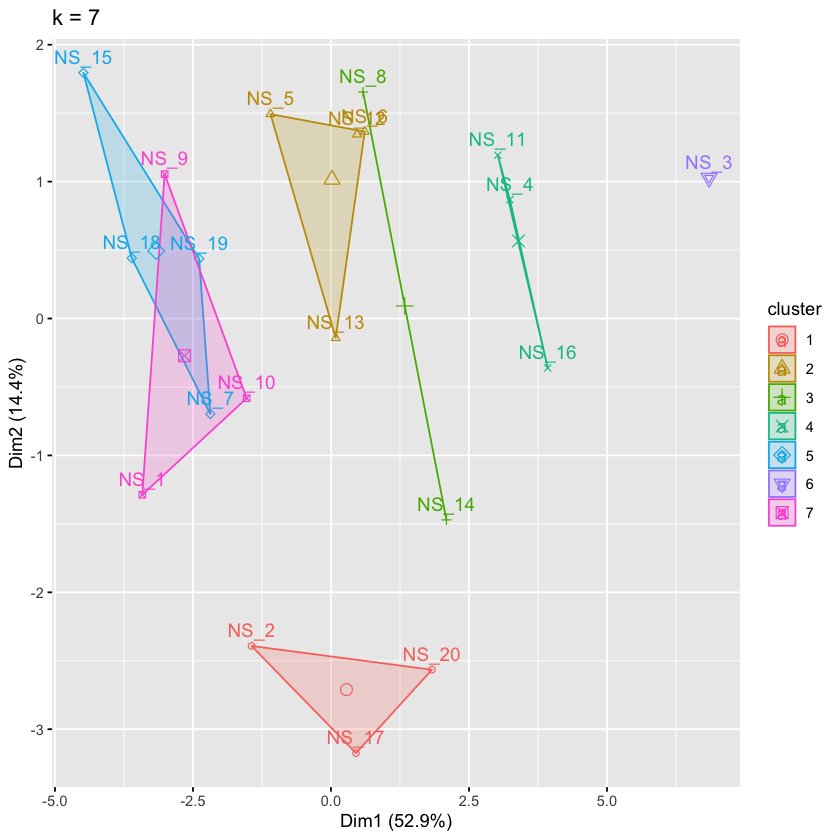

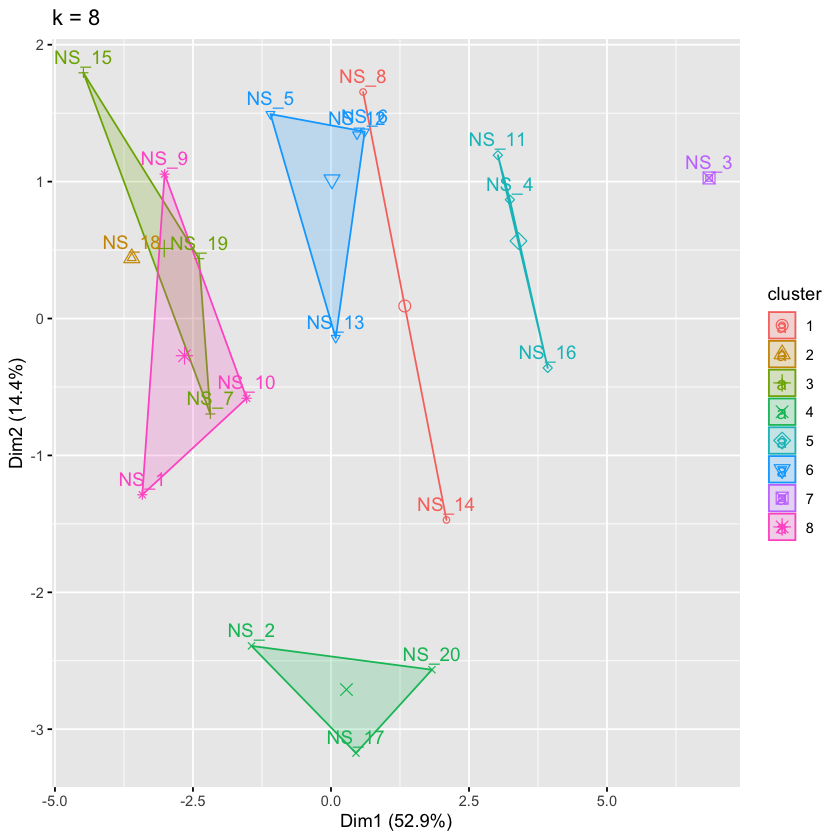

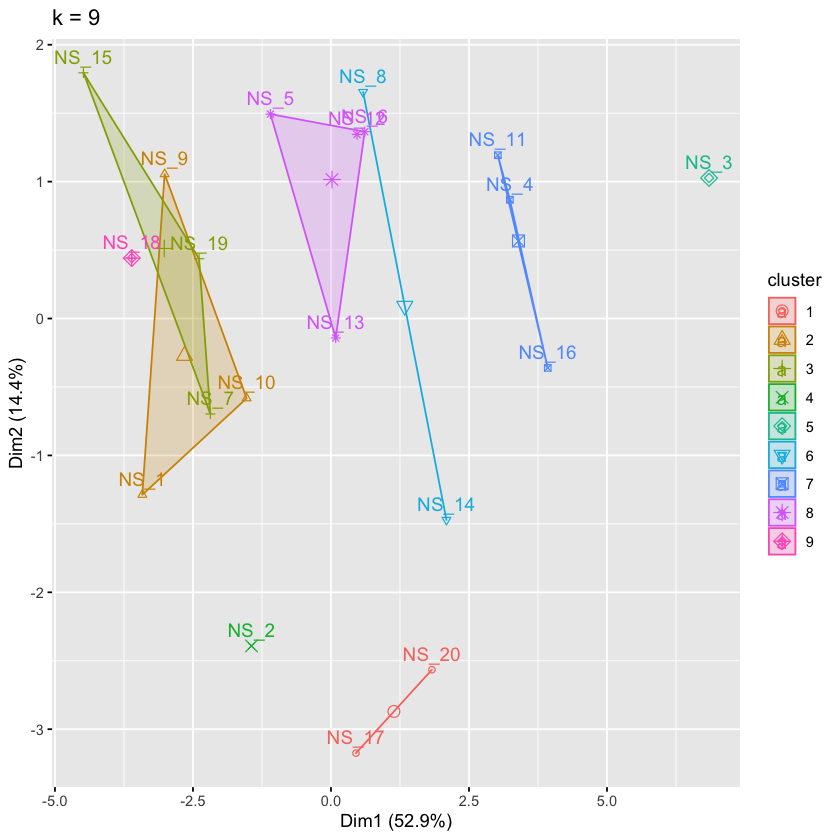

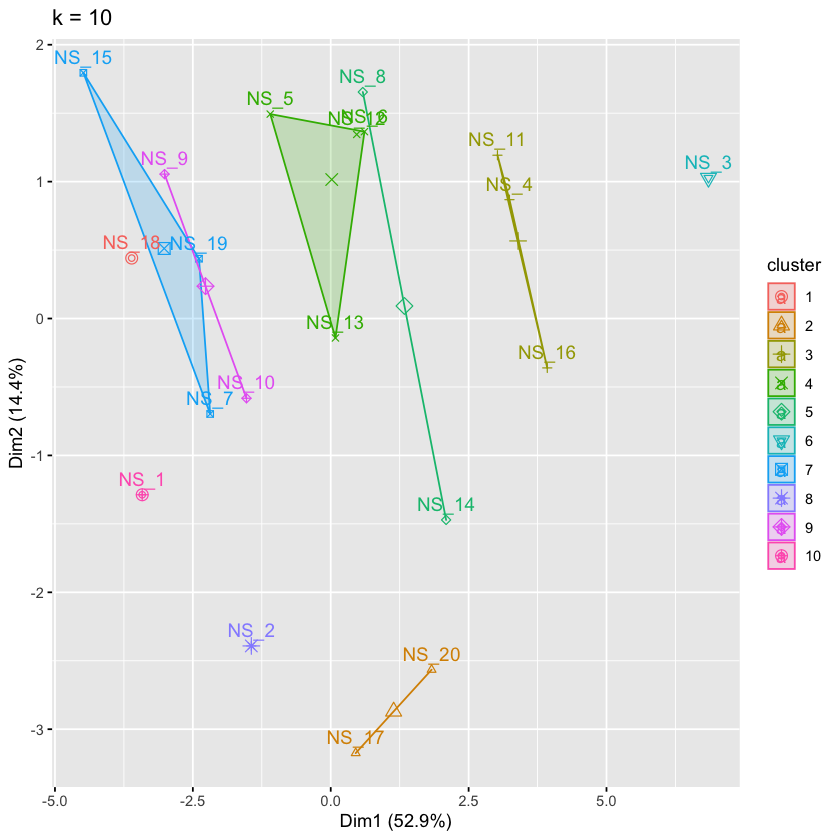

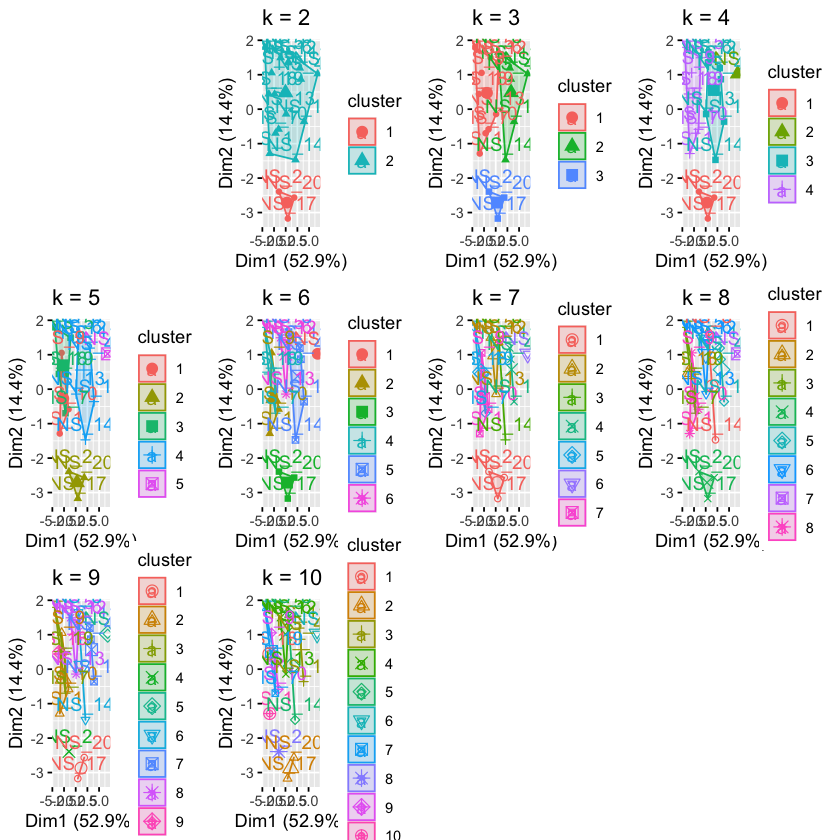

In [4]:
# Since the initial cluster assignments are random, we need to set the seed to ensure reproducibility
set.seed(151)

# Running the basic cluster analysis code
# kmeans(x, centers, iter.max = 10, nstart = 1)
# where:
#   x: numeric matrix, numeric data frame or a numeric vector
#   centers: Possible values are the number of clusters (k) or a set of initial (distinct) cluster centers. If a number, a random set of (distinct) rows in x is chosen as the initial centers.
#   iter.max: The maximum number of iterations allowed. Default value is 10.
#   nstart: The number of random starting partitions when centers is a number.
#   This means that R will try nstart different random starting assignments and then select the best results corresponding to the one with the lowest within cluster variation. The default value of nstart in R is one. But, it’s strongly recommended to compute k-means clustering with a large value of nstart such as 25 or 50, in order to have a more stable result.

# Testing different numbers of clusters (k)

cluster_plots = list()
for (i in 2:10){
    cytokines_Cluster_k <- kmeans(cytokines, centers = i, nstart = 25)
    cluster_plots[[i]] <- fviz_cluster(cytokines_Cluster_k, data = cytokines) + ggtitle(paste0("k = ",i))
    print(cluster_plots[[i]])
}

#viewing all plots
ggarrange(plotlist = cluster_plots)

Estimating optimal number of clusters for cytokines.

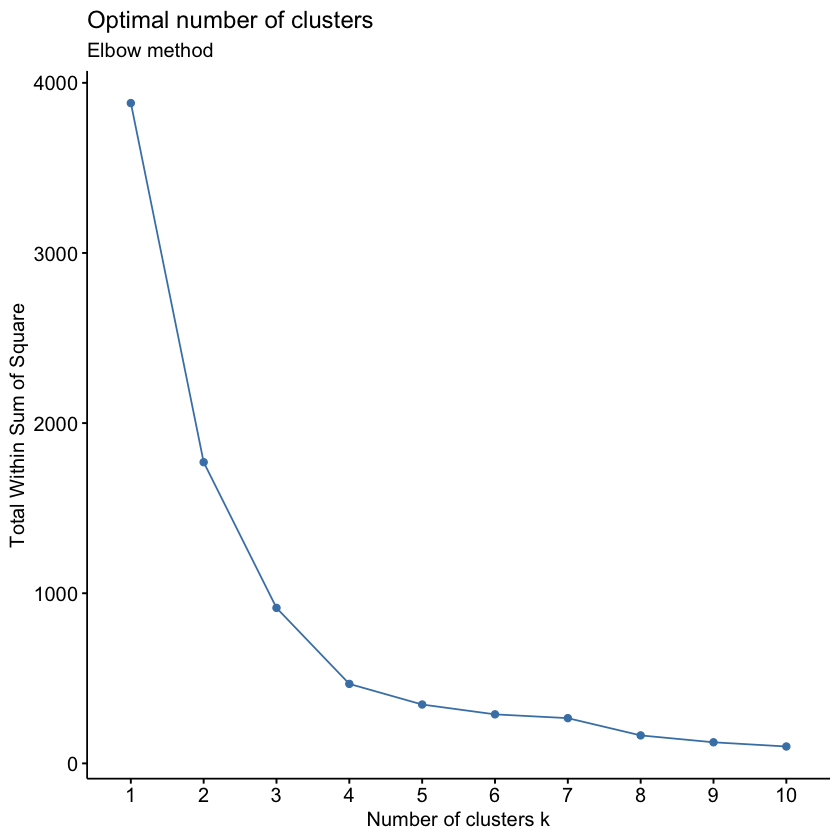

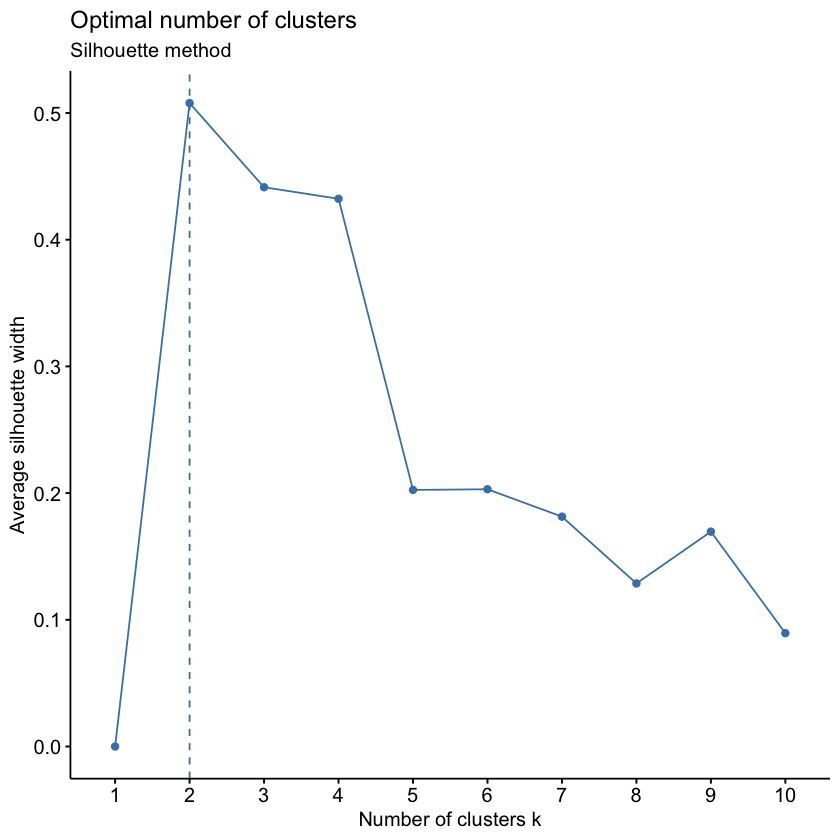

In [5]:
tcytokines = data.frame(t(cytokines))
fviz_nbclust(tcytokines, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # suggests 4
fviz_nbclust(tcytokines, kmeans, method = "silhouette") + 
  labs(subtitle="Silhouette method") # suggests 2

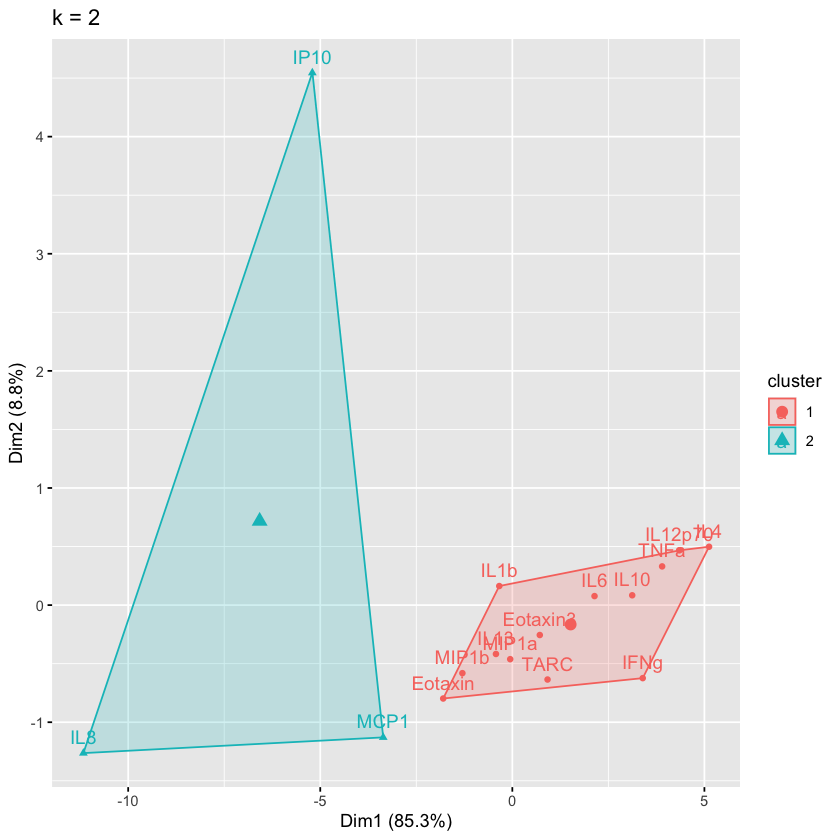

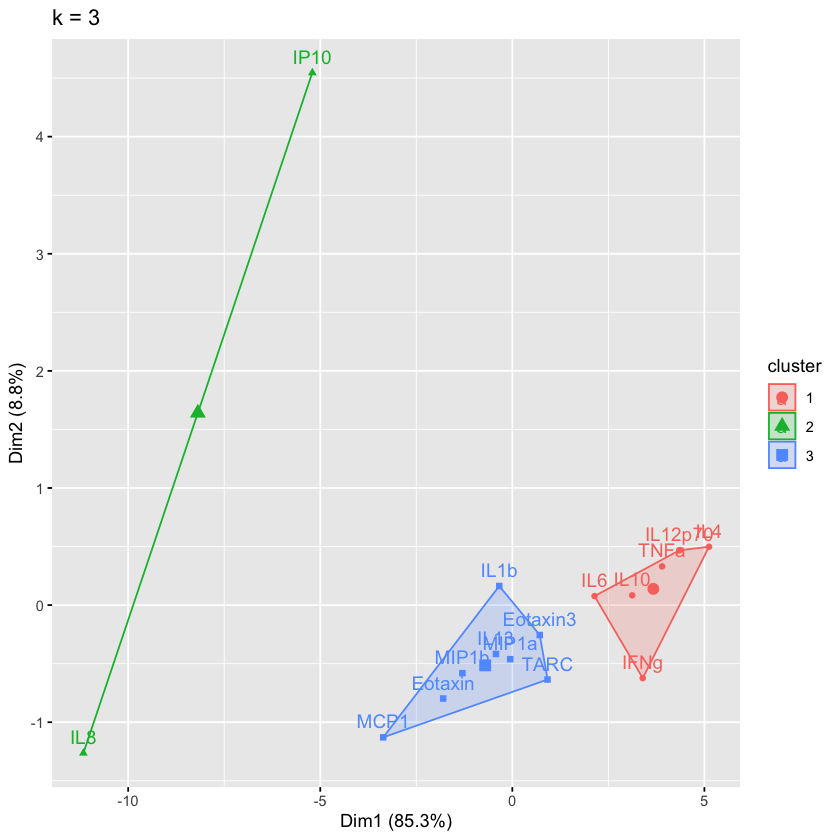

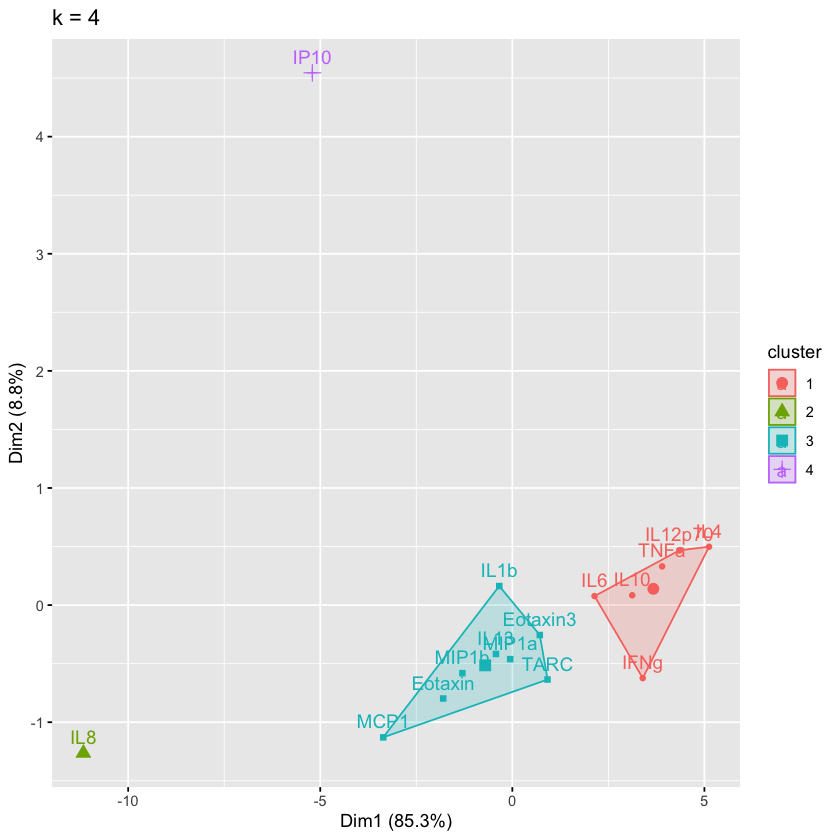

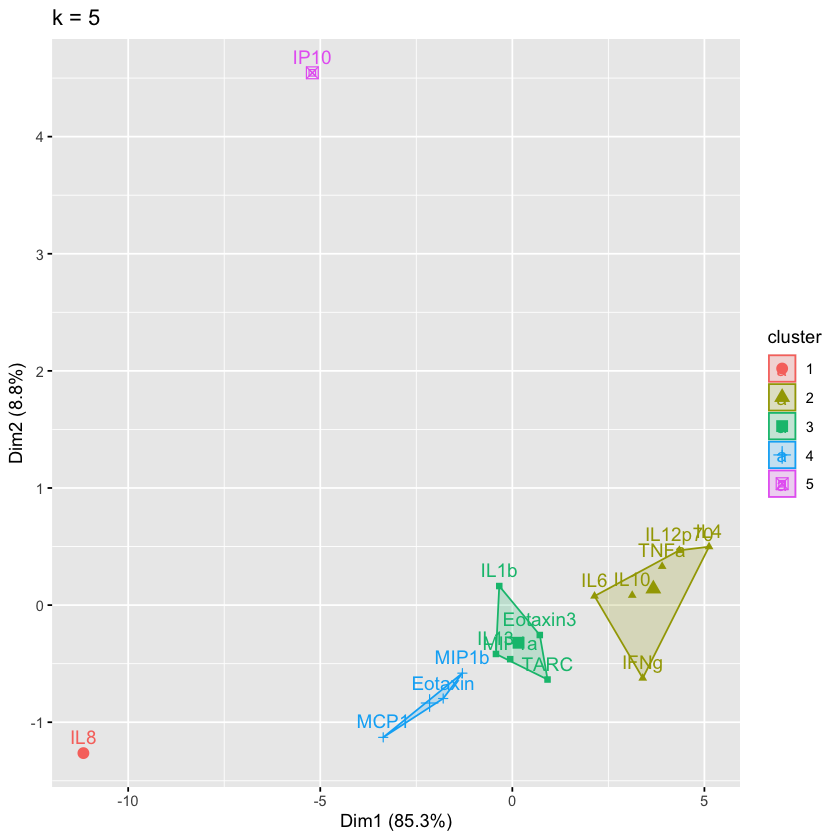

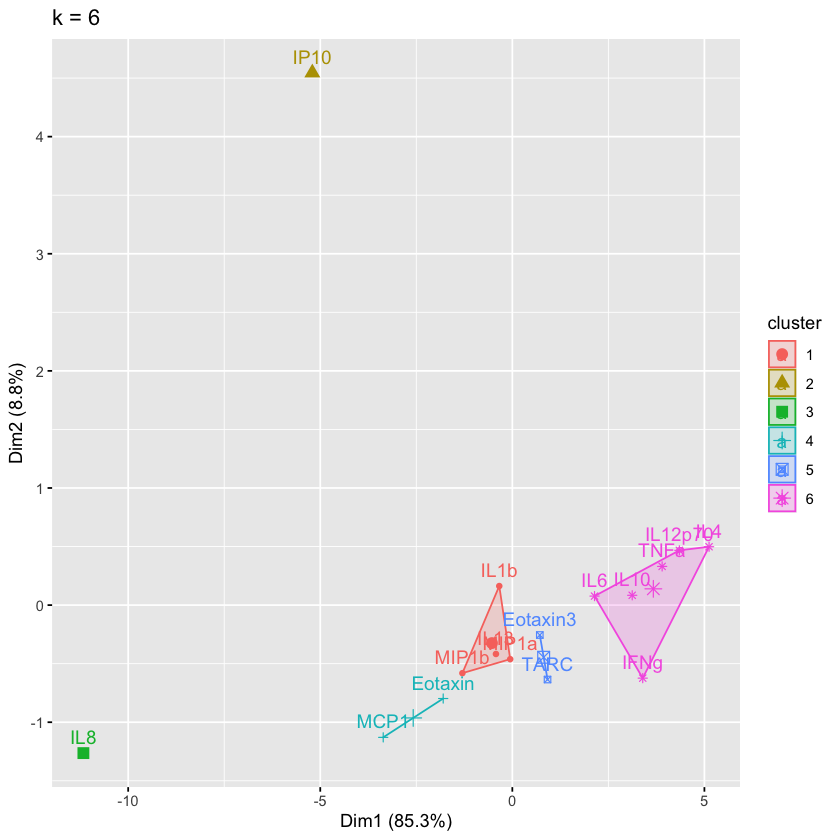

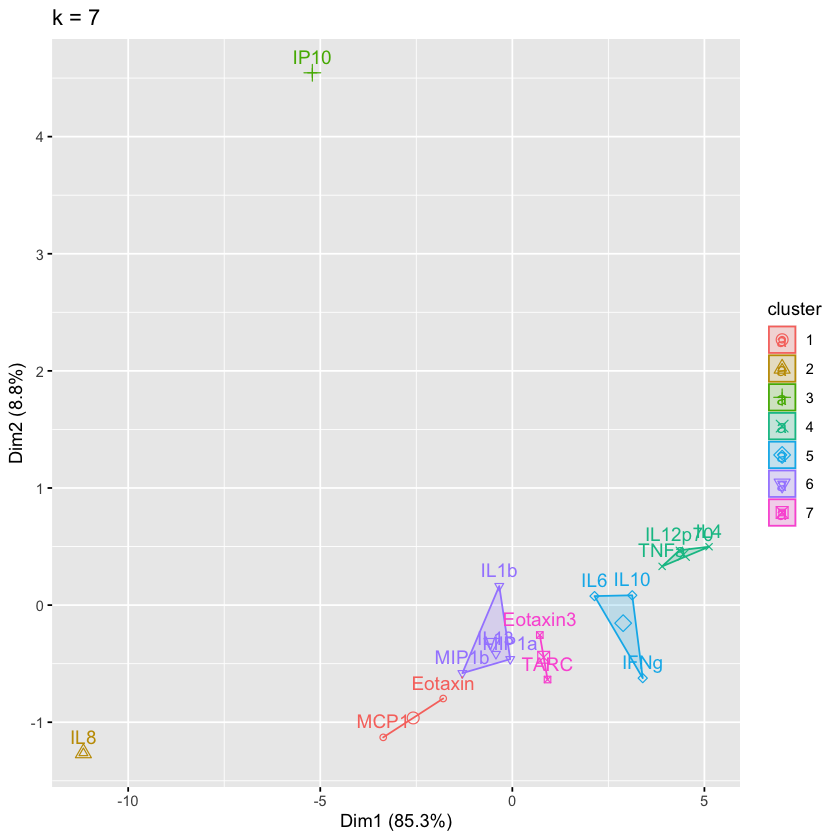

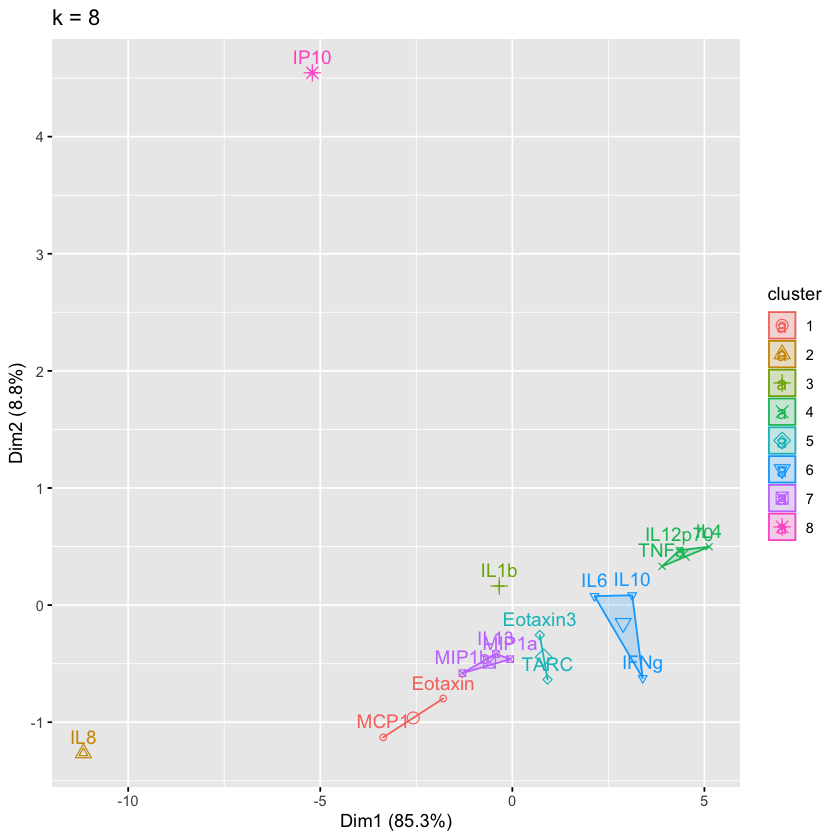

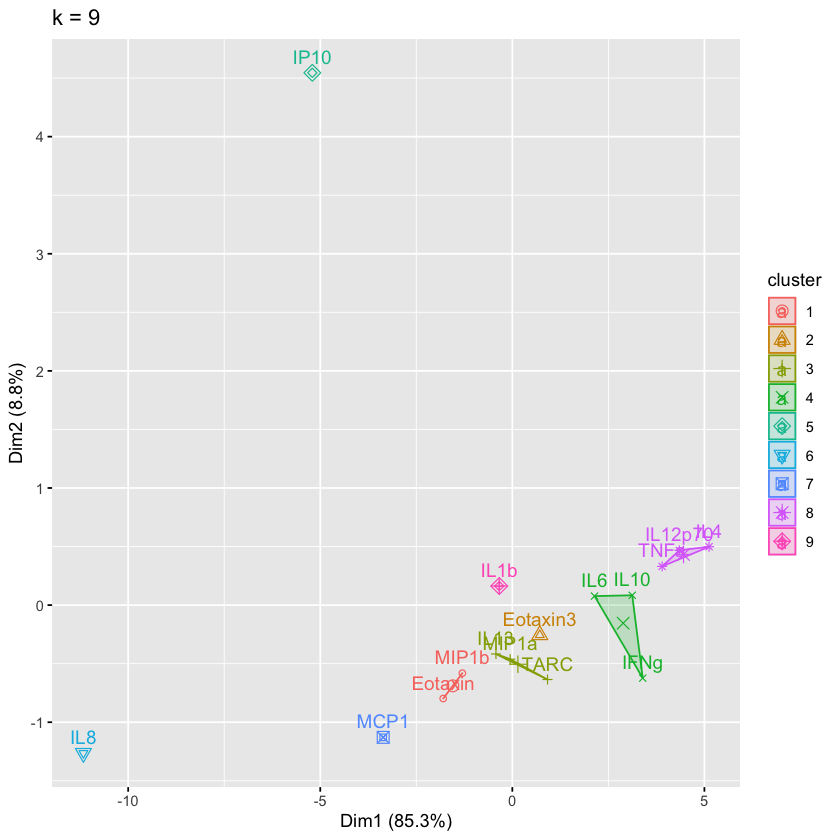

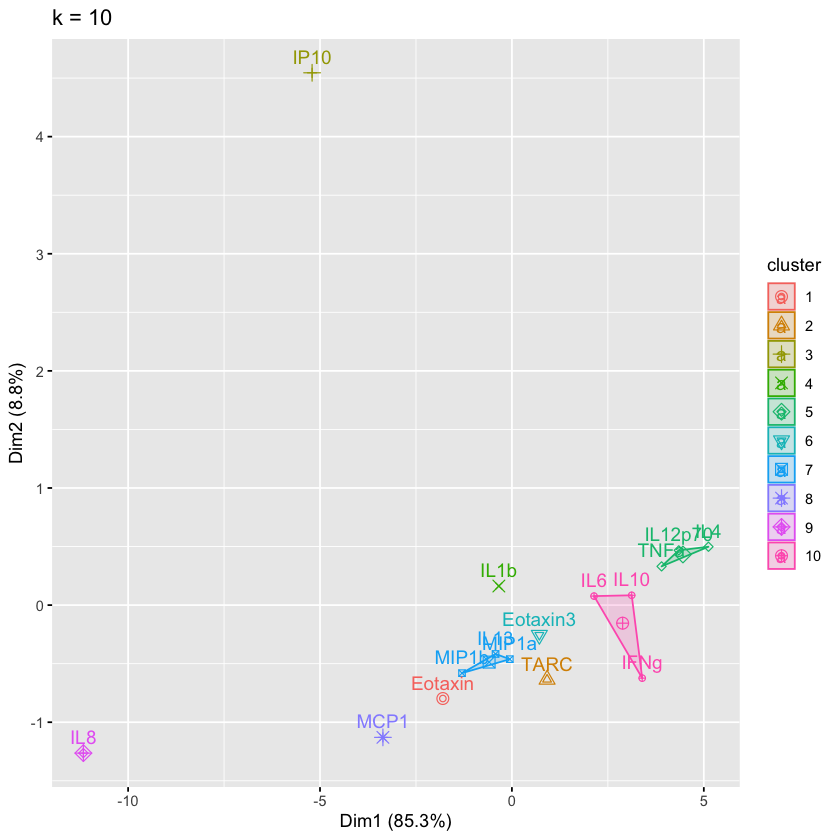

In [6]:
# Testing different numbers of clusters (k)
cluster_plots = list()
for (i in 2:10){
    cytokines_Cluster_k <- kmeans(tcytokines, centers = i, nstart = 25)
    cluster_plots[[i]] <- fviz_cluster(cytokines_Cluster_k, data = tcytokines) + ggtitle(paste0("k = ",i))
    print(cluster_plots[[i]])
}

In [8]:
#exporting clusters
# Exporting final cytokine cluster assignments (k=3)
tcytokines_Cluster_k3 <- kmeans(tcytokines, centers = 3, nstart=25)
cytokines_cluster_k3 <- as.data.frame(tcytokines_Cluster_k3$cluster) 
colnames(cytokines_cluster_k3)[1] <- "Cluster"

#write.csv(cytokines_cluster_k3, paste0(Output,"/", cur_date, "cytokines_cluster_assignments.csv"), row.names=TRUE)

Since three appears to be the optimal number that will be visualized. 

# Baseline Cluster Visualization of Both Datasets (Figure 6)

Using fviz_cluster is a bit clunky, so the results from kmeans needs to parsed in a way that ggplot will understand. Also combining dfs from both datasets from the NELF compartment to visualize together.

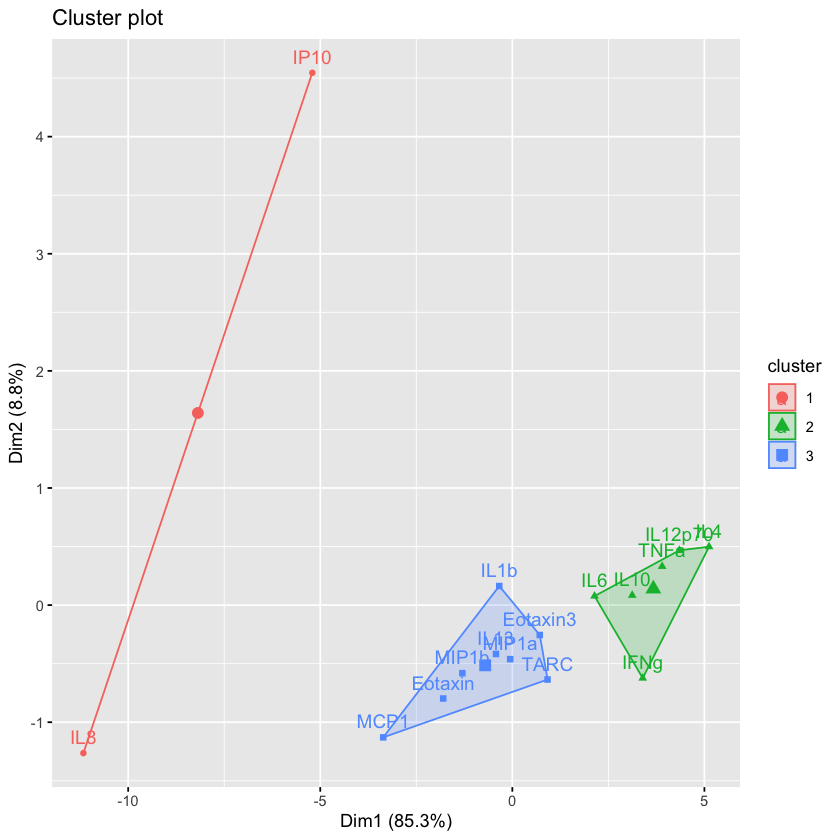

In [11]:
fviz_cluster(tcytokines_Cluster_k3, data = tcytokines)

In [25]:
#parsing prcomp for visualization
trythis<-stats::prcomp(tcytokines, scale = TRUE, center = TRUE)
all_scores_new_df<-as.data.frame(scores(trythis)) %>%
    select(PC1, PC2) %>%
    rownames_to_column(var = "Protein")
all_scores_new_df$Cluster <- tcytokines_Cluster_k3$cluster
all_scores_new_df$Dataset = rep("Validation NELF Dataset", times = length(all_scores_new_df$PC1))

grp.1.cytokines <- all_scores_new_df[all_scores_new_df$Cluster == 1, ][chull(all_scores_new_df %>% filter(Cluster ==1) %>% select(PC1, PC2) ), ]  # hull values for cluster 1
grp.2.cytokines <- all_scores_new_df[all_scores_new_df$Cluster == 2, ][chull(all_scores_new_df %>% filter(Cluster ==2) %>% select(PC1, PC2) ), ]  # hull values for cluster 2
grp.3.cytokines <- all_scores_new_df[all_scores_new_df$Cluster == 3, ][chull(all_scores_new_df %>% filter(Cluster ==3) %>% select(PC1, PC2) ), ]  # hull values for cluster 3
all_hulls_new_df <- rbind(grp.1.cytokines,grp.2.cytokines,grp.3.cytokines) 

In [26]:
#reading in scores and hulls dfs from original dataset
og_scores_df = read_csv("041621_NELF_scores.csv")%>%
    select(PC1, PC2, Cluster, Protein)
og_scores_df$Dataset = rep("Original NELF Dataset", times = length(og_scores_df$PC1))
og_hulls_df = read_csv("041621_NELF_hulls.csv")%>%
    select(PC1, PC2, Cluster, Protein)
og_hulls_df$Dataset = rep("Original NELF Dataset", times = length(og_hulls_df$PC1))
                          
#combining and viewing below
all_scores_df = rbind(og_scores_df, all_scores_new_df)
all_scores_df$Dataset = factor(all_scores_df$Dataset, levels = c("Original NELF Dataset", "Validation NELF Dataset"))
all_hulls_df = rbind(og_hulls_df, all_hulls_new_df)
all_hulls_df$Dataset = factor(all_hulls_df$Dataset, levels = c("Original NELF Dataset", "Validation NELF Dataset"))
head(all_scores_df)
head(all_hulls_df)


── Column specification ────────────────────────────────────────────────────────
cols(
  PC1 = col_double(),
  PC2 = col_double(),
  PC3 = col_double(),
  PC4 = col_double(),
  PC5 = col_double(),
  PC6 = col_double(),
  PC7 = col_double(),
  PC8 = col_double(),
  PC9 = col_double(),
  PC10 = col_double(),
  PC11 = col_double(),
  PC12 = col_double(),
  PC13 = col_double(),
  PC14 = col_double(),
  Cluster = col_double(),
  Protein = col_character(),
  Compartment = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  PC1 = col_double(),
  PC2 = col_double(),
  PC3 = col_double(),
  PC4 = col_double(),
  PC5 = col_double(),
  PC6 = col_double(),
  PC7 = col_double(),
  PC8 = col_double(),
  PC9 = col_double(),
  PC10 = col_double(),
  PC11 = col_double(),
  PC12 = col_double(),
  PC13 = col_double(),
  PC14 = col_double(),
  Cluster = col_double(),
  Protein = col_character(),
  Compartment = col_character()
)




PC1,PC2,Cluster,Protein,Dataset
<dbl>,<dbl>,<dbl>,<chr>,<fct>
-1.4837936,-0.37325290,3,Eotaxin,Original NELF Dataset
0.7505718,-1.04251406,3,Eotaxin3,Original NELF Dataset
-7.0500961,-0.49034208,2,Fractalkine,Original NELF Dataset
4.6869896,0.42263944,1,I309,Original NELF Dataset
2.4935464,-0.21910385,1,IFNg,Original NELF Dataset
3.4361668,-0.04689914,1,IL10,Original NELF Dataset


PC1,PC2,Cluster,Protein,Dataset
<dbl>,<dbl>,<dbl>,<chr>,<fct>
3.436167,-0.04689914,1,IL10,Original NELF Dataset
2.493546,-0.21910385,1,IFNg,Original NELF Dataset
2.395497,-0.05728780,1,TNFa,Original NELF Dataset
2.509288,0.53888370,1,IL17D,Original NELF Dataset
4.686990,0.42263944,1,I309,Original NELF Dataset
4.742547,0.30157171,1,IL4,Original NELF Dataset


Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


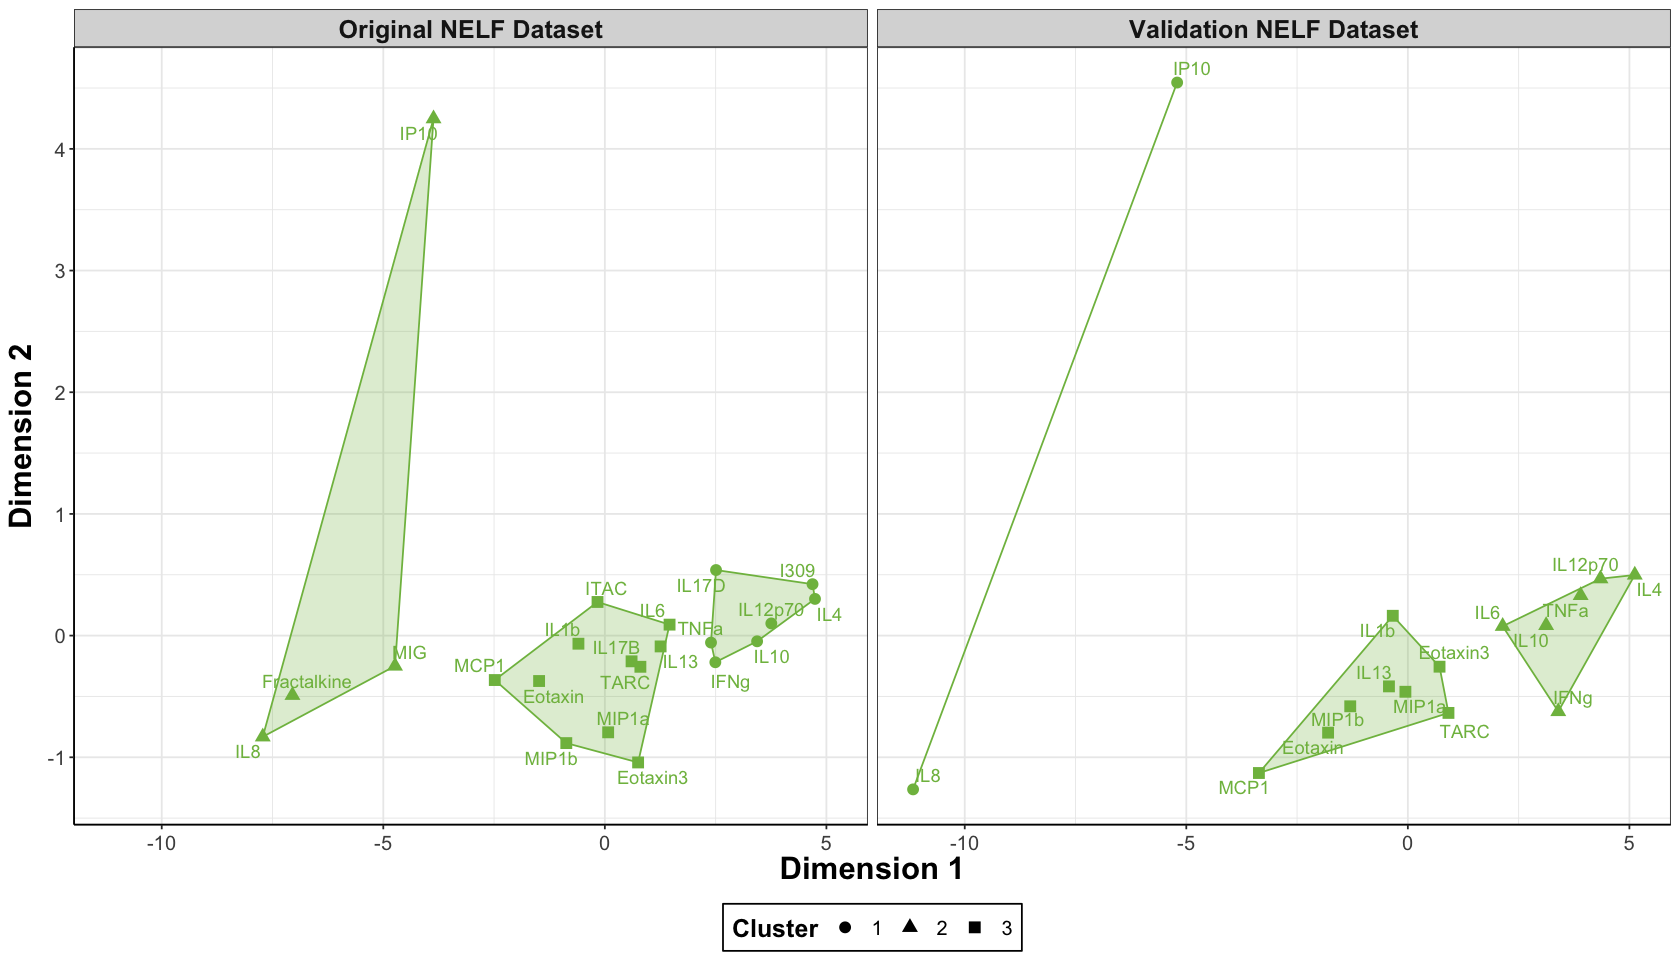

In [10]:
options(repr.plot.width=14, repr.plot.height=8) #changing size
Figure6 = ggplot() + 
  geom_point(data = all_scores_df, aes(x = PC1, y = PC2, color = '#7fbb4d', shape = as.factor(Cluster)), size = 3) + 
  geom_text_repel(data = all_scores_df, aes(x = PC1, y = PC2, color = '#7fbb4d', label = Protein), 
                  show.legend = FALSE) + 
  geom_polygon(data = all_hulls_df, aes(x = PC1, y = PC2, group = as.factor(Cluster), color = '#7fbb4d', 
                                        fill = '#7fbb4d'), alpha = 0.25, show.legend = FALSE) + 

  facet_wrap(~Dataset) + 

  theme_bw() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = 'bottom',
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  xlab('Dimension 1') + ylab('Dimension 2') + #changing axis labels 
  scale_color_manual(name = 'Cluster',
                      values = c('#7fbb4d', '#7fbb4d', '#7fbb4d')) +
  scale_fill_manual(name = 'Cluster',
                      values = c('#7fbb4d', '#7fbb4d', '#7fbb4d')) +

  guides(color = FALSE, shape = guide_legend(title = "Cluster")) #removing legend for color and changing title

Figure6

In [11]:
ggsave(Figure6, 
       filename = 'Figure6.pdf',
       path = Output,
       width = 14, height = 8)

Looking at loadings (weights) to determine which cytokines are driving the clusters.

In [27]:
pca_cytokines = prcomp(cytokines, scale = TRUE, center = TRUE)
new_pca_weights = pca_cytokines$rotation 
head(new_pca_weights)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
Eotaxin,0.2005387,-0.31625018,-0.27668116,-0.09530918,0.38775219,-0.2305162,0.46589534,-0.35332993,0.19371804,-0.31931867,0.0002150916,-0.04543552,0.02668497,0.2584947,-0.112777543,0.08329388
Eotaxin3,0.2368270,-0.18546050,-0.33075264,-0.21563575,0.31469097,0.2796760,-0.41152990,0.05966426,-0.07005076,0.01263451,-0.4647002817,-0.09919639,0.24862468,-0.2707699,-0.177564755,-0.07708925
IFNg,0.2274042,-0.17362135,0.13052269,0.50688980,0.20596757,0.5531307,0.16049789,0.08736619,-0.27994091,-0.04838169,0.2274211940,-0.16225834,0.20765533,0.1155960,0.202841033,0.07757189
IL10,0.3236597,0.08754443,-0.07733138,0.14338513,0.10753004,-0.1314218,-0.08860178,-0.11321167,0.24050344,0.06334173,0.4789560610,0.11782318,0.10869934,-0.3448138,-0.004511088,-0.61292059
IL12p70,0.3012512,0.20306134,0.08850015,0.08486708,0.02909185,-0.2002843,0.39319567,0.07251530,-0.25026523,-0.08727167,-0.2680206679,0.33158338,0.01446686,-0.5638989,0.155497920,0.24032292
IL13,0.2936952,-0.10012001,0.10482618,-0.17131579,-0.15363601,-0.4176856,-0.22891258,0.37640996,-0.15354738,-0.22559310,0.2737063052,-0.08044577,0.48615540,0.1603033,-0.052312579,0.22493161


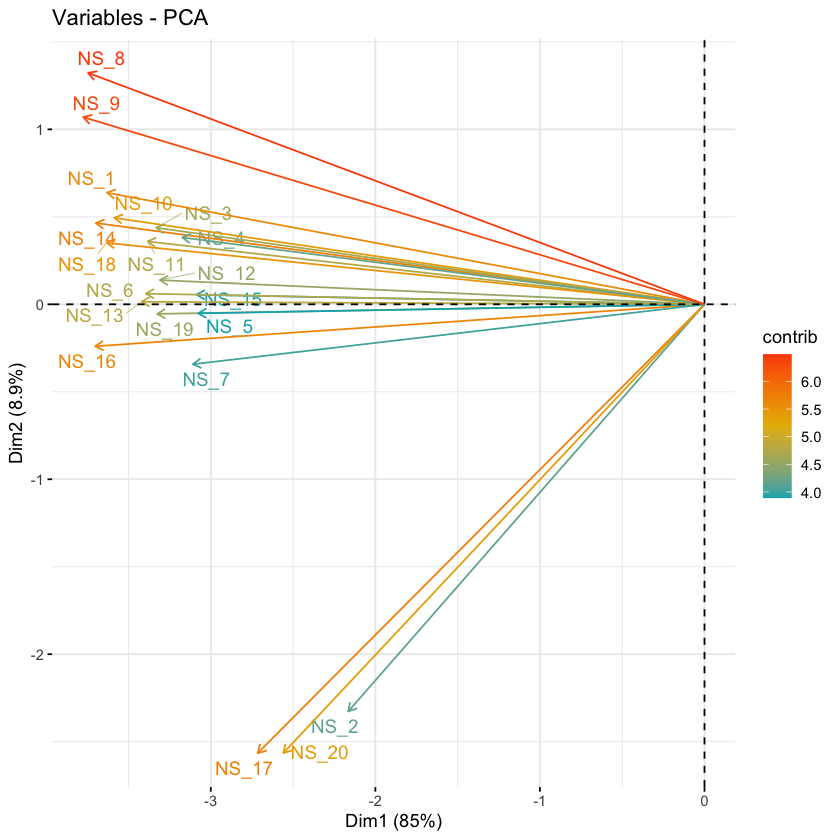

In [28]:
tcytokines = data.frame(t(cytokines)) 
pca_tcytokines = tcytokines %>% prcomp()

#shows individuals that are driving clusters
fviz_pca_var(pca_tcytokines,
             col.var = "contrib", # Color by contributions to the PC
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE     # Avoid text overlapping
             )

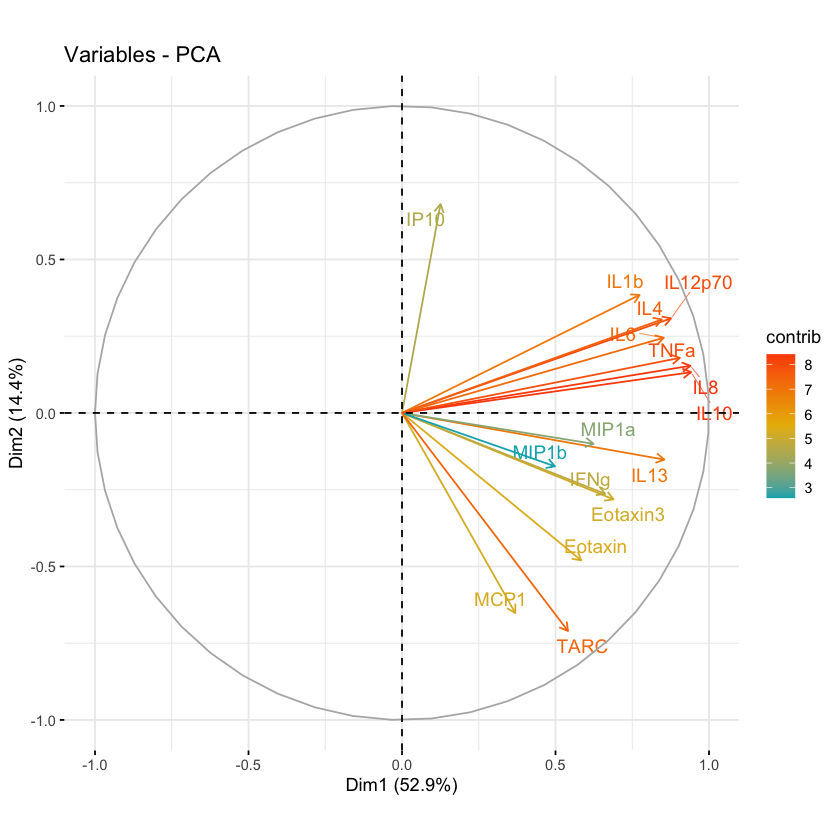

In [31]:
#shows degree to which each cytokine contributes to eigenvectors
fviz_pca_var(pca_cytokines,
             col.var = "contrib", # Color by contributions to the PC
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE     # Avoid text overlapping
             )

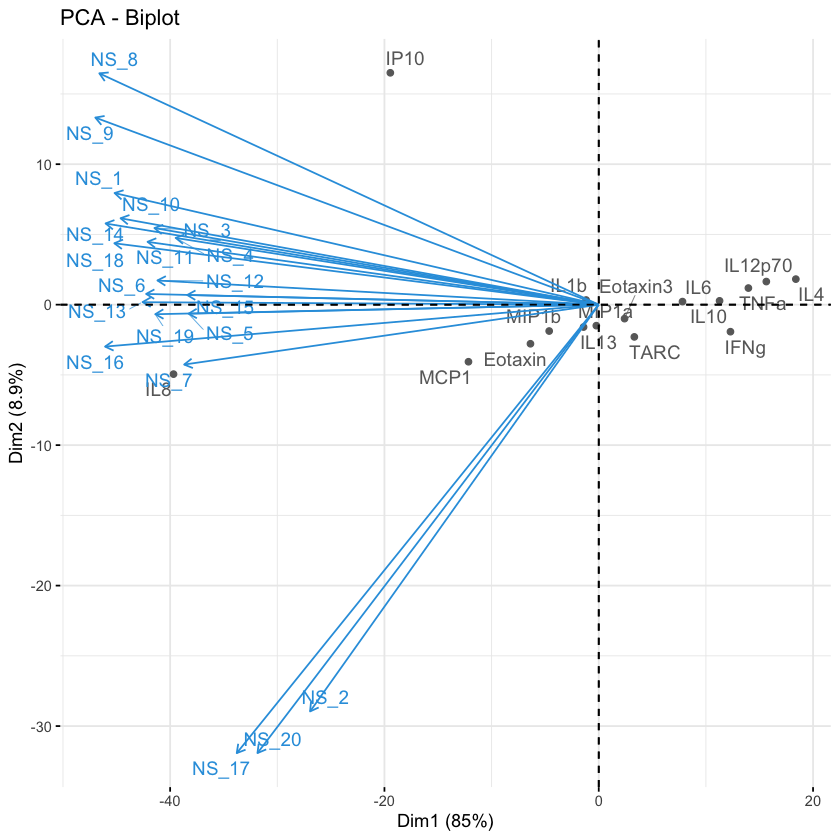

In [32]:
fviz_pca_biplot(pca_tcytokines, repel = TRUE,
                col.var = "#2E9FDF", # Variables color
                col.ind = "#696969")  # Individuals color